<a href="https://colab.research.google.com/github/MaCarlosOficial/ChatBotGEMINI/blob/main/ChatGemini_Imersao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Autor: Professor: Marcelo Aparecido Carlos

As Informações utilizadas para o contexto, foram extraídas do site: https://feriasvivas.org.br/

In [1]:
import pandas as pd
import time
import numpy as np
from google.colab import userdata

# Assistente
import google.generativeai as genai
import spacy

In [2]:
gemini_api_key = userdata.get('SECRET_KEY')
genai.configure(api_key=gemini_api_key)
modeloIA = genai.GenerativeModel('gemini-pro')

Esse arquivo será disponibilizado no GIT você pode fazer o upload no COLAB e rodar

In [8]:
# Criar uma lista para armazenar os arquivos de texto
filename='texto_imersao_gemini.txt'
# Abre o arquivo e leia o texto
with open(filename, "r" , encoding='latin-1', errors='ignore') as f:
  texto = f.read()
  texto = texto.lower().split('\n')

#Criar um Dataframe a partir da lista de textos
df = pd.DataFrame(texto, columns = ['Textos'])

# Define a coluna de texto para ser o texto bruto com as novas linhas removidas
df.to_csv('arq_docs.csv')
df.head()

,Textos
0,para você que deseja viajar e não sabe qual de...
1,quem possui costume de viajar sozinho não deve...
2,sempre fique atento às condições climáticas no...
3,"nas férias, mantenha os mesmos cuidados que to..."
4,busque uma agência de viagem que se preocupa c...


<Axes: >

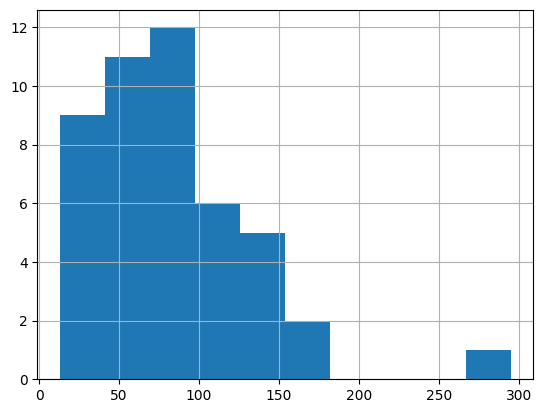

In [9]:
#tokenização usando a biblioteca do gemini
df = pd.read_csv('arq_docs.csv', index_col=0)
df.columns = ['Textos']

# Tokeniza o texto e grava o nr de tokens
df['n_tokens'] = df.Textos.apply(lambda x: modeloIA.count_tokens(str(x)).total_tokens)

# Visualiza a distribuição do numero de tokens por linha do Dataframe usando a histograma
df.n_tokens.hist()
#se for necessário use uma função para quebrar os textos

In [15]:
#fazer o embedding do texto
i = 0
embeddings = []
for text in df['Textos']:
  try:
    # Criar uma conclusão usando a pergunta e o contexto
    embedding = genai.embed_content(model="models/embedding-001",content=text,task_type="retrieval_document",title="Embedding of list of strings")
    embeddings.append(embedding)
  except Exception as e:
    print('Erro na linha: ',i, '\n ERRO:',e)
  i+=1

df['embeddings'] = embeddings
df.to_csv('arq_embeddings.csv')
df.head()

,Textos,n_tokens,embeddings,distances
0,para você que deseja viajar e não sabe qual de...,27,"{'embedding': [0.005641051, -0.012573205, -0.0...",0.539911
1,quem possui costume de viajar sozinho não deve...,30,"{'embedding': [-0.040234998, -0.017803041, -0....",0.526097
2,sempre fique atento às condições climáticas no...,30,"{'embedding': [-0.0034096434, -0.008118383, -0...",0.496365
3,"nas férias, mantenha os mesmos cuidados que to...",36,"{'embedding': [0.0045236796, 0.022304248, 0.00...",0.517932
4,busque uma agência de viagem que se preocupa c...,13,"{'embedding': [0.02324243, 0.0018579119, -0.01...",0.538852


In [16]:
def similaridade_cosseno(u,v):
  return np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v))

def create_context(question, df, max_len=2300):
    """
    Cria um contexto para uma pergunta encontrando o contexto mais similar no conjunto de embeddings gerado.
    """
    # Obter a embeddings para a pergunta que foi feita
    q_embeddings = genai.embed_content(model="models/embedding-001",content=question,task_type="retrieval_document",title="Embedding of list of strings")
    df['distances'] = df.embeddings.apply(lambda x: similaridade_cosseno(q_embeddings['embedding'],x['embedding']))

    returns = []
    cur_len = 0

    # Classifique por distância e adicione o texto ao contexto
    for i, row in df.sort_values('distances', ascending=False).iterrows():

        # Adicionar o comprimento do texto ao comprimento atual
        cur_len += row['n_tokens'] + 4

        # Se o contexto for muito longo, quebre
        if cur_len > max_len:
            break

        # Caso contrário, adicione-o ao texto que está sendo retornado
        returns.append(row["Textos"])

    # Retornar o contexto
    return "\n\n###\n\n".join(returns)

In [17]:
def responder_perguntas(
                    df=df,
                    modelo="gemini-pro",
                    question=None,
                    max_len=1800,
                    debug=False,
                    max_tokens=300):
  """
    Responder a uma pergunta com base no contexto mais semelhante dos textos do dataframe
  """

  context = create_context(
        question,
        df=df,
        max_len=max_len,
  )
  if debug:
      print("Contexto:\n" + context)
      print("\n\n")

  prompt = f"Responda as perguntas com base no contexto abaixo, e se a pergunta não puder ser respondida diga \"Eu não sei responder isso\"\n\Contexto: {context}\n\n---\n\nPergunta: {question}"

  try:
      # Criar uma conclusão usando a pergunta e o contexto
      response = modelo.generate_content(
          { 'role': 'user', 'parts': prompt }
      )
      return response.text
  except Exception as e:
        print(e)
  return

In [ ]:
print("Entre com sua PERGUNTA, ou escreva SAIR para finalizar: ")
while True:
  mensagem = input('')
  if mensagem.upper() == "SAIR":
    break
  else:
    resposta = responder_perguntas(df=df,modelo=modeloIA,question=mensagem,debug=False)
    print("RESPOSTA: ",resposta,'\n')

print("Até mais....")

Entre com sua DÚVIDA ou escreva SAIR para finalizar: 
Quero viajar nas minhas férias. Qual melhor sugestão para quem gosta de natureza?
RESPOSTA:  Tefé no Amazonas 

O que tem para fazer em Tefé no Amazonas?
RESPOSTA:  Estar em contato com a natureza, tirar fotos de animais, passeios pelo rio Tefé, acampamento, atividades em rios, arvorismo, buggies, cachoeiras, caminhada, canionismo, cicloturismo, embarcações, espeleoturismo, fora de estrada, jet ski, mergulho, montanhismo, parquinho infantil, piscinas, turismo equestre, voo livre 

Me dê mais mais opções de destinos
RESPOSTA:  * Alter do Chão - Amazonas
* Foz do Iguaçu - Paraná
* Tefé - Amazonas
* Serra da Mantiqueira - Minas Gerais
* Jericoacoara - Ceará 

Quero apenas opções para quem gosta de natureza
RESPOSTA:  - Foz do Iguaçu - Paraná
- Serra da Mantiqueira - Minas Gerais
- Monte Verde - Minas Gerais
- Alter do Chão - Amazonas
- Tefé - Amazonas 

o que tem para fazer em Monte Verde? 
RESPOSTA:  Contato com a natureza, tranquilid

KeyboardInterrupt: Interrupted by user